<a href="https://colab.research.google.com/github/KianSimonVeiser/HCAI-PRAK/blob/main/HCAI_PRAK_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Ziel des Modells</h1>
<p> Das Ziel des Modells ist es, basierend auf persönlichen Daten vorrauszusagen, wie viel Geld die Person mutmaßlich verdient. Wir entscheiden uns für für einen Entscheidungsbaum (decision Tree), denn wir halten ein hohes Maß an erklärbarkeit für wichtig, um Schlüsse aus unseren Prognosen ziehen zu können.</p>

https://www.kaggle.com/datasets/wenruliu/adult-income-dataset

path = kagglehub.dataset_download("wenruliu/adult-income-dataset")

https://www.youtube.com/watch?v=wxS5P7yDHRA


<h1>1. Importieren des Datensatzes</h1>


In [ ]:
import pandas as pd
import kagglehub # Für download von Kaggle Dataset
import os # Importieren, um Pfade sicher zu verknüpfen, os ist eine Standardbibliothek in Python für Betriebssystem-Interaktionen.

# 1. Hole den Pfad zum *Ordner*, in den das Dataset heruntergeladen wurde
dataset_dir = kagglehub.dataset_download("wenruliu/adult-income-dataset")

# 2. Definiere den Namen der CSV-Datei, die du laden möchtest
#    (Bei diesem Dataset heißt sie wahrscheinlich "adult.csv")
csv_file = "adult.csv"

# 3. Kombiniere den Ordnerpfad und den Dateinamen zu einem vollständigen Pfad
full_path = os.path.join(dataset_dir, csv_file)

# 4. Lese die CSV-Datei mit pandas ein
df = pd.read_csv(full_path)

# Jetzt ist 'df' ein pandas DataFrame
print(type(df))
print(df.head())
print(df.tail())



100%|██████████| 652k/652k [00:00<00:00, 21.5MB/s]

Extracting files...


<class 'pandas.core.frame.DataFrame'>
   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   



<h1>2. Daten aufräumen



<h3>2.1. Spaltennamen und Werte bereinigen</h3>
<p>Wir entfernen Leerzeichen aus Spaltennamen und den Werten in den kategorischen Spalten, um Inkonsistenzen zu vermeiden.

In [ ]:
# 2.1.1. Spaltennamen und Werte bereinigen
# Entferne führende/nachfolgende Leerzeichen in Spaltennamen


# Entferne führende/nachfolgende Leerzeichen in allen kategorischen Werten
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()

<h3>2.2. Fehlende Werte behandeln (Imputation)</h3>
<p>Im adult-Datensatz werden fehlende Werte als ? gespeichert. Wir wandeln diese in pd.NA (den offiziellen Pandas-Marker für fehlende Werte) um und füllen sie dann mit dem häufigsten Wert (Modus) auf.

In [ ]:
# --- KORRIGIERTER IMPUTATIONS-BLOCK ---

# 2.2.1. Fehlende Werte (durch '?' repräsentiert) in NA umwandeln
# Viele ältere Datasets – insbesondere aus UCI – speichern fehlende Werte nicht als echte NA,
# sondern als das Zeichen '?'.
# pandas erkennt '?' NICHT automatisch als fehlenden Wert.
# Deshalb ersetzen wir zuerst alle Vorkommen von '?' durch pandas' offizielles NA-Objekt.
df = df.replace('?', pd.NA)


# 2.2.2. Fehlende Werte durch den Modus ersetzen (Imputation)
# In diesem Datensatz sind insbesondere drei kategorische Spalten betroffen:
# 'workclass', 'occupation' und 'native-country'.
# Der ursprüngliche Code hatte fälschlich 'country' verwendet, aber die Spalte heißt 'native-country'.
missing_cols = ['workclass', 'occupation', 'native-country']

# Wir iterieren über jede dieser Spalten, um die fehlenden Werte zu ersetzen.
for col in missing_cols:
    # Berechne den Modus der Spalte.
    # Der Modus ist der am häufigsten vorkommende Wert.
    # Beispiel: Wenn 'Private' am häufigsten in workclass vorkommt,
    #           wird 'Private' der Ersatzwert für fehlende Einträge.
    mode_value = df[col].mode()[0]
    # df[col].mode() gibt eine Serie zurück; [0] entnimmt den ersten (und in 99% der Fälle einzigen) Modus.

    # Ersetze alle NA-Werte in der Spalte durch den Modus.
    # fillna() gibt eine neue Serie zurück; wir überschreiben wieder df[col].
    df[col] = df[col].fillna(mode_value)

# Ausgabe für den Nutzer: Bestätigung + Anzahl verbleibender fehlender Werte
print(f"\nImputation erfolgreich durchgeführt.")
print(f"Anzahl fehlender Werte (NA) nach Imputation: {df.isnull().sum().sum()}")
# df.isnull().sum().sum() zählt alle NA-Werte über alle Spalten hinweg.
# Falls die Imputation korrekt lief, sollte das Ergebnis 0 sein (oder nur noch NA in anderen Spalten, falls vorhanden).



Imputation erfolgreich durchgeführt.
Anzahl fehlender Werte (NA) nach Imputation: 0


<h1>3. Feature Engineering (Zielvariable & Encoding)

<h3>3.1. Zielvariable transformieren</h3>
<p>Die Spalte income wird in eine binäre Variable umgewandelt (1 für >50K, 0 für alle anderen), was für die binäre Klassifikation notwendig ist.

In [ ]:
# 3.1.1. Zielvariable 'income' in binäre 0/1-Spalte umwandeln
df['income_binary'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

# 3.1.2. Ursprüngliche Zielspalte entfernen
df = df.drop('income', axis=1)

print("Zielvariable wurde in 'income_binary' (0 und 1) umgewandelt.")

Zielvariable wurde in 'income_binary' (0 und 1) umgewandelt.


<h3>3.2. Kategorische Daten numerisch machen (One-Hot Encoding)</h3>
<p>Der Random Forest benötigt numerische Features. Wir verwenden One-Hot Encoding (pd.get_dummies), um jede Kategorie in eine separate 0/1-Spalte umzuwandeln.

In [ ]:
# 3.2.1. Kategorische Spalten identifizieren
categorical_cols = df.select_dtypes(include=['object']).columns

# 3.2.2. One-Hot Encoding durchführen
# drop_first=True, um Multikollinearität (Redundanz) zu vermeiden
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

print(f"DataFrame-Form nach Encoding: {df.shape}")
print("Der DataFrame ist nun vollständig numerisch.")

DataFrame-Form nach Encoding: (48842, 98)
Der DataFrame ist nun vollständig numerisch.


<h1>4. Aufteilung (Trainings- und Test-Sets)

In [ ]:
from sklearn.model_selection import train_test_split

# 4.1. X (Features) und y (Zielvariable) definieren
X = df.drop('income_binary', axis=1)  # Features sind alle Spalten außer der Zielspalte
y = df['income_binary']              # Zielvariable ist die binäre Einkommensspalte

# 4.2. Aufteilung durchführen (70% Training / 30% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y          # Wichtig für ungleich verteilte Klassen
)

print(f"Aufteilung abgeschlossen.")
print(f"X_train Größe: {X_train.shape}")
print(f"X_test Größe: {X_test.shape}")
print("y_test:")
print(y_test)
#print(y_train)

Aufteilung abgeschlossen.
X_train Größe: (34189, 97)
X_test Größe: (14653, 97)
y_test:
39432    0
25976    0
3591     0
25158    0
6288     0
        ..
32526    0
45036    1
22263    0
27989    0
19299    0
Name: income_binary, Length: 14653, dtype: int64


<h1>5. Bauen des Decision Tree

<h3>5.1. Fitting

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_train, y_train)
print("Default Parameter:")
clf.get_params()

Default Parameter:


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

<h3>5.2 Predictions errechnen
<p>5.2.1 Precictions Wahr Falsch

In [ ]:
import numpy as np
predictions = clf.predict(X_test)
#np.set_printoptions(threshold=np.inf)
print(predictions)

[0 0 0 ... 0 0 0]


<p>5.2.2 Predictions mit Prozentzahlen

In [ ]:
predictions_proba = clf.predict_proba(X_test)
print(predictions_proba)

[[0.66849348 0.33150652]
 [0.66849348 0.33150652]
 [0.97849388 0.02150612]
 ...
 [0.97849388 0.02150612]
 [0.97849388 0.02150612]
 [0.97849388 0.02150612]]


<h3>5.3 Qualität beurteilen</h>

<b1> 5.3.0 wir brauchen mehr Als nur die Accuracy!!!




<b1>

<p>5.3.1Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: ", accuracy)

Accuracy:  0.8448781819422644


<body> 5.3.2 Bias im Datensatz plotten <body>

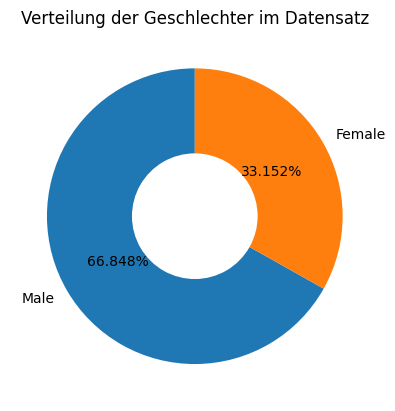

In [ ]:
import matplotlib.pyplot as plt
gender = df['gender_Male'].value_counts() # Die Diskrepanz der Datein in der Kathegorie aufzeigen
labels = ['Male','Female']
sizes = gender.values

fig, ax = plt.subplots() # Donut Diagramm (Danke Gemini)
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.3f%%',
    startangle=90,
    wedgeprops={'width': 0.575}
)
ax.set_title('Verteilung der Geschlechter im Datensatz')
plt.show()

<h1> 6. Logische Regression <h1>

<h1> Training der Modelle </h1>
<b> Konfusions matrix erstellen um zu visualiseren, wie viele Testdaten korrekt oder inkorrekt durch den Descision Tree eingeschätzt werden.</b>
<b>
kleiner als 50 Tausen richtig, right negative
kleiner als 50 Tausen falsch, false negative
größer als 50 Tausend richtig, right positive
größer als 50 Tausend Falsch, false positive



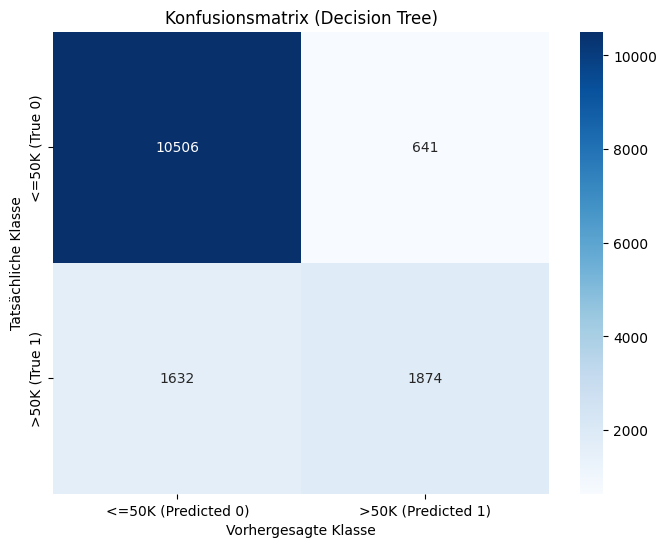


True Positives (TP): 1874
True Negatives (TN): 10506
False Positives (FP): 641
False Negatives (FN): 1632


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Konfusionsmatrix berechnen
# y_test: Tatsächliche Labels (aus Zelle 7)
# predictions: Vorhersagen des Decision Tree (aus Zelle 9)
cm = confusion_matrix(y_test, predictions)

# 2. Beschriftungen für die Heatmap definieren
# Da 0 = "<=50K" und 1 = ">50K" ist (siehe Zelle 5)
labels = ['<=50K (Predicted 0)', '>50K (Predicted 1)']

# 3. Konfusionsmatrix visualisieren (als Heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,        # Zeigt die Zahlen in den Zellen an
    fmt='d',           # Formatiert die Zahlen als Dezimalzahl (Integer)
    cmap='Blues',      # Farbschema
    xticklabels=labels,# Beschriftungen der X-Achse (Vorhersagen)
    yticklabels=['<=50K (True 0)', '>50K (True 1)'] # Beschriftungen der Y-Achse (Tatsächlich)
)

plt.title('Konfusionsmatrix (Decision Tree)')
plt.ylabel('Tatsächliche Klasse')
plt.xlabel('Vorhergesagte Klasse')
plt.show()

# Optional: Zusätzliche Metriken aus der Konfusionsmatrix berechnen
# (Wenn Sie die Classification Report Funktion noch nicht verwenden)
TN, FP, FN, TP = cm.ravel()

print(f"\nTrue Positives (TP): {TP}") # Richtig vorhergesagte >50K
print(f"True Negatives (TN): {TN}") # Richtig vorhergesagte <=50K
print(f"False Positives (FP): {FP}") # Falsch alarmierte (Personen, die <=50K verdienen, aber als >50K vorhergesagt wurden)
print(f"False Negatives (FN): {FN}") # Übersehene (Personen, die >50K verdienen,


Cost Sensitive Variante


--- Gesamtkosten-Analyse ---
Kosten (Standardmodell):  12,065
Kosten (Cost-Sensitive):  7,123
--------------------------


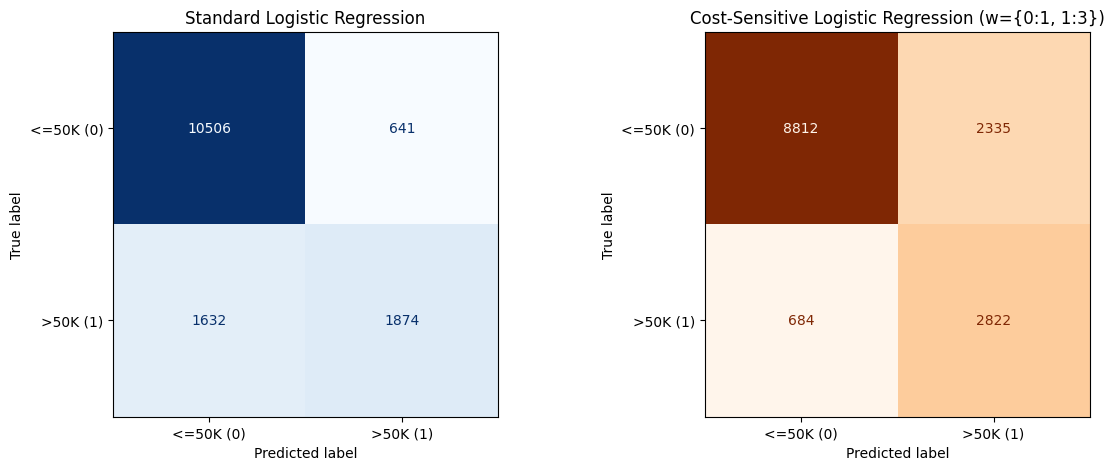

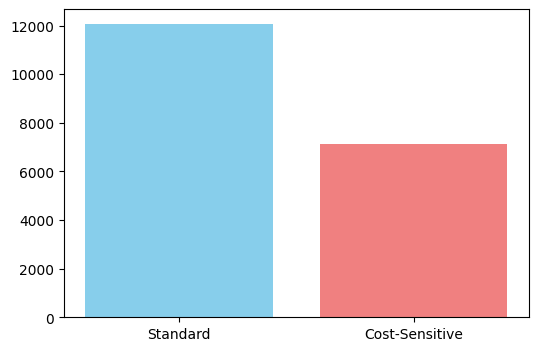

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.linear_model import LogisticRegression


"""COST_MATRIX = {
    (0, 0): 0,  # True Negative (Korrekt <=50K)
    (0, 1): 1,  # False Positive (Fehler: Ist <=50K, wird als >50K vorhergesagt)
    (1, 0): 7,  # False Negative (Fehler: Ist >50K, wird als <=50K vorhergesagt - SEHR TEUER)
    (1, 1): 0   # True Positive (Korrekt >50K)
}"""

COST_MARTIX = {0: 1, 1: 7}

y_pred_std = predictions

def calculate_total_cost(y_true, y_pred, cost_matrix):
    total_cost = 0
    # Die Funktion iteriert über alle Vorhersagen und summiert die Kosten
    for yt, yp in zip(y_true, y_pred):
        total_cost += cost_matrix[(yt, yp)]
    return total_cost


fig, ax = plt.subplots(1, 2, figsize=(14, 5))
class_names = ['<=50K (0)', '>50K (1)'] # Labels für die Achsen



# Alternative Berechnung der predcost über extra Variable
#model_cost = LogisticRegression(class_weight={0: 1, 1: 7}, max_iter=60000, solver='liblinear', random_state=42)
#model_cost.fit(X_train, y_train)
#y_pred_cost = model_cost.predict(X_test)


# Cost-sensitive Logistic Regression

# Cost-sensitive Logistic Regression
model_cost = LogisticRegression(class_weight={0: 1, 1: 3}, max_iter=60000, solver='liblinear', random_state=42)
model_cost.fit(X_train, y_train)

y_pred_cost = model_cost.predict(X_test)


# Standardmodell
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_std,
    display_labels=class_names, ax=ax[0], colorbar=False, cmap=plt.cm.Blues
)
ax[0].set_title("Standard Logistic Regression")

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_cost,
    display_labels=class_names, ax=ax[1], colorbar=False, cmap=plt.cm.Oranges
)
ax[1].set_title("Cost-Sensitive Logistic Regression (w={0:1, 1:3})")

cost_std = calculate_total_cost(y_test, y_pred_std, COST_MATRIX)
cost_cost = calculate_total_cost(y_test, y_pred_cost, COST_MATRIX)

print("\n--- Gesamtkosten-Analyse ---")
print(f"Kosten (Standardmodell):  {cost_std:,}")
print(f"Kosten (Cost-Sensitive):  {cost_cost:,}")
print("--------------------------")

# Visualisierung der Gesamtkosten (als Balkendiagramm)
costs = [cost_std, cost_cost]
model_names = ['Standard', 'Cost-Sensitive']

plt.figure(figsize=(6, 4))
bars = plt.bar(model_names, costs, color=['skyblue', 'lightcoral'])